# <div style="text-align:center; padding:15px; color:white; margin:0; font-size:150%; font-family:'Times New Roman'; background-color:#7E8083   ; overflow:hidden"><b>Import libraries and load data</b></div>

In [1]:
import os

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from process import process


In [2]:
dir = '/root/workspace/forecast/data/predict/dataset/10k-15k'
rand = 42

In [3]:
def count_files_in_directory(directory):
    i = 0
    # 获取目录下的所有文件和文件夹
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.is_file():
                df = pd.read_csv(entry)
                if len(df) < 10:
                    continue
                i += 1

                # Shift the 'Commit Count' column up by one and assign it to 'target' column
                df['Target'] = df['Commit Count'].shift(-2)
                df['Target'] = df['Target'].fillna(df['Commit Count'])

                if 'tensor_list' not in locals():
                    tensor_list = df
                else:
                    tensor_list = pd.concat([tensor_list, df], ignore_index=True)
    print(i)

    return tensor_list

In [4]:
all = count_files_in_directory(dir)

42


array([[<Axes: title={'center': 'Modified File Count (Average)'}>,
        <Axes: title={'center': 'Created Issues'}>,
        <Axes: title={'center': 'Closed Issues'}>,
        <Axes: title={'center': 'Label Counts (Average)'}>],
       [<Axes: title={'center': 'Created PRs'}>,
        <Axes: title={'center': 'Closed PRs'}>,
        <Axes: title={'center': 'PR Length'}>,
        <Axes: title={'center': 'Added Code Lines'}>],
       [<Axes: title={'center': 'Removed Code Lines'}>,
        <Axes: title={'center': 'Truck Factor'}>,
        <Axes: title={'center': 'Fork Count'}>,
        <Axes: title={'center': 'Release Count'}>],
       [<Axes: title={'center': 'Download Count'}>,
        <Axes: title={'center': 'Develop Time'}>,
        <Axes: title={'center': 'Star'}>,
        <Axes: title={'center': 'Target'}>]], dtype=object)

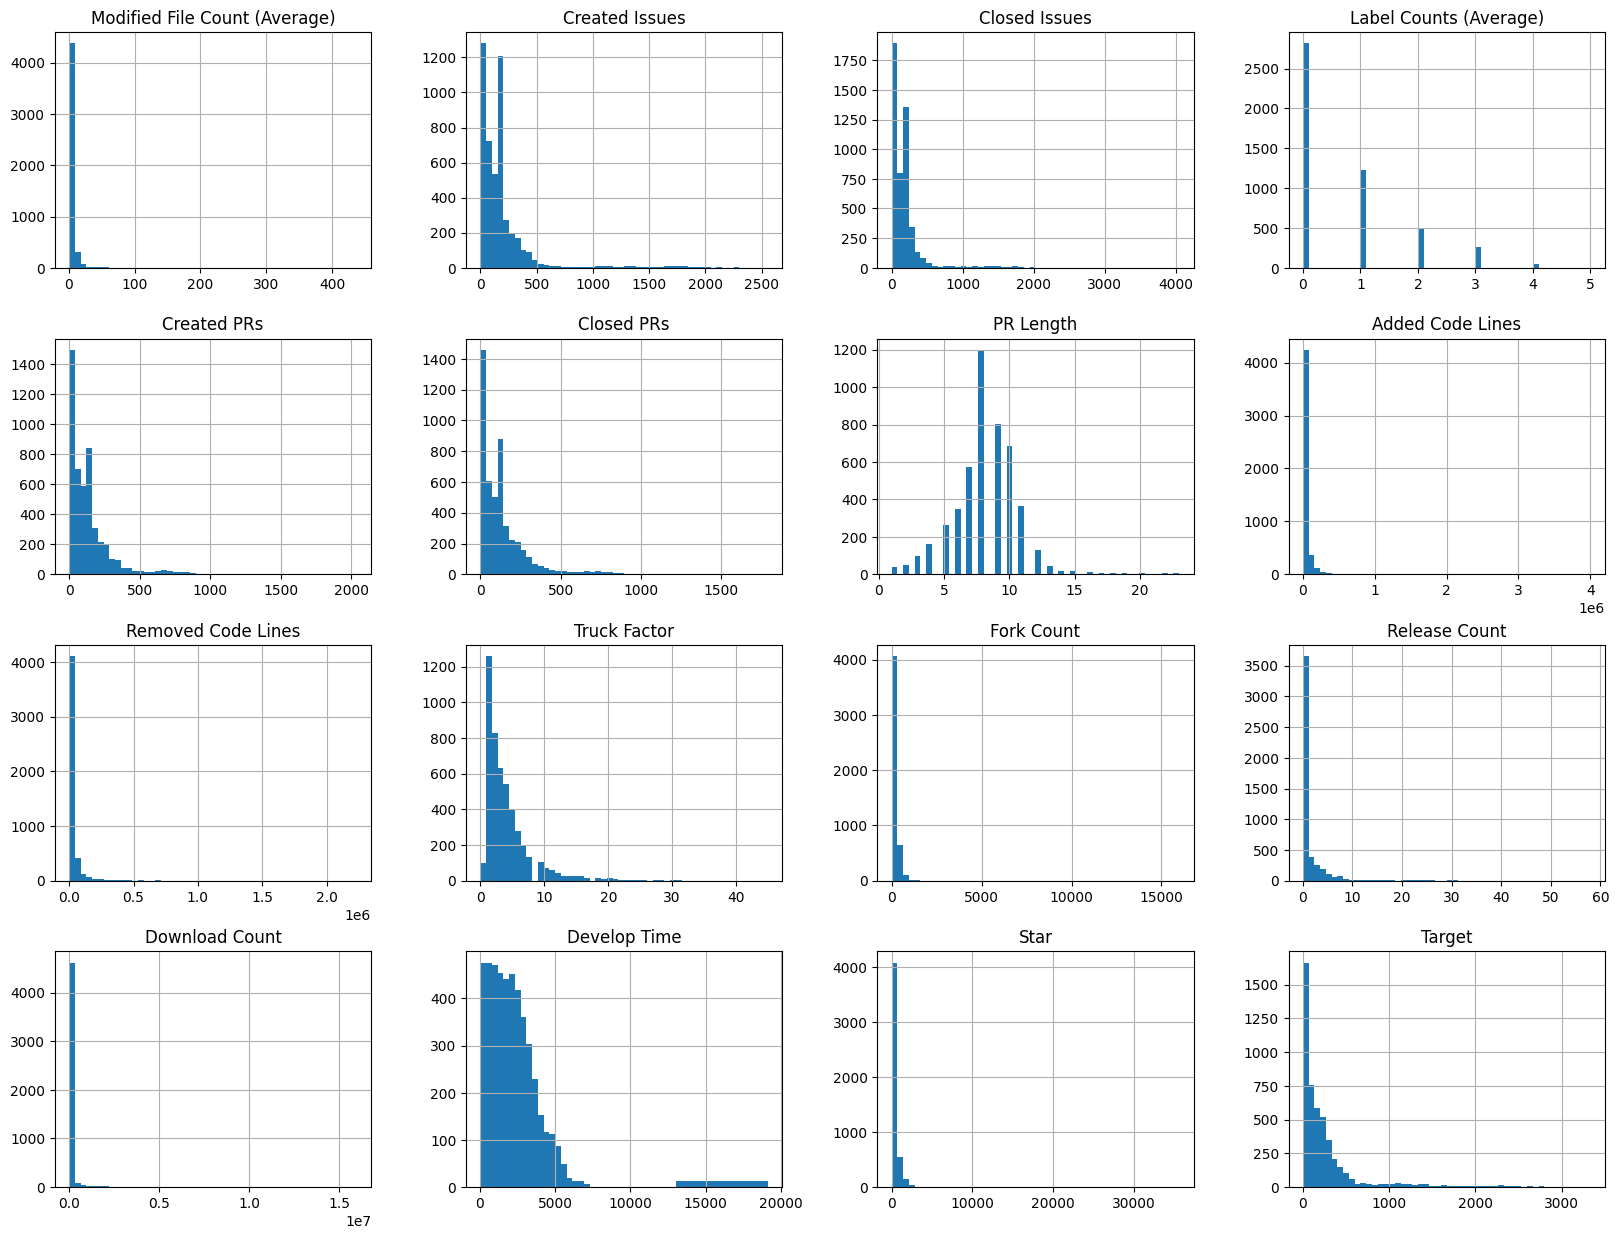

In [5]:
data, _ = process(all)
data.hist(bins=50, figsize=(20,15))

In [6]:
# 分离特征和目标变量
features = data.drop("Target", axis=1)
target = data["Target"].copy()

# <div style="text-align:center; padding:15px; color:white; margin:0; font-size:150%; font-family:'Times New Roman'; background-color:#7E8083   ; overflow:hidden"><b>Model</b></div>

In [7]:
from imblearn.over_sampling import RandomOverSampler, BorderlineSMOTE, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

X = features.copy()
Y = target.copy()

# # Remove classes with fewer than 2 instances
# class_counts = Y.value_counts()
# to_keep = class_counts[class_counts >= 2].index
# X = X[Y.isin(to_keep)]
# Y = Y[Y.isin(to_keep)]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=rand, shuffle=True)

rus = RandomOverSampler(random_state=rand)
# X_train, Y_train = rus.fit_resample(X_train, Y_train)

In [ ]:
test_dir = '/root/workspace/forecast/data/predict/dataset/sep'
test = count_files_in_directory(test_dir)
test, _ = process(test)
X_test_1 = test.drop("Target", axis=1)
Y_test_1 = test["Target"].copy()

test_dir = '/root/workspace/forecast/data/predict/dataset/1'
test2 = count_files_in_directory(test_dir)
test2, _ = process(test2)
X_test_2 = test2.drop("Target", axis=1)
Y_test_2 = test2["Target"].copy()

462
1


<Axes: xlabel='Target', ylabel='Count'>

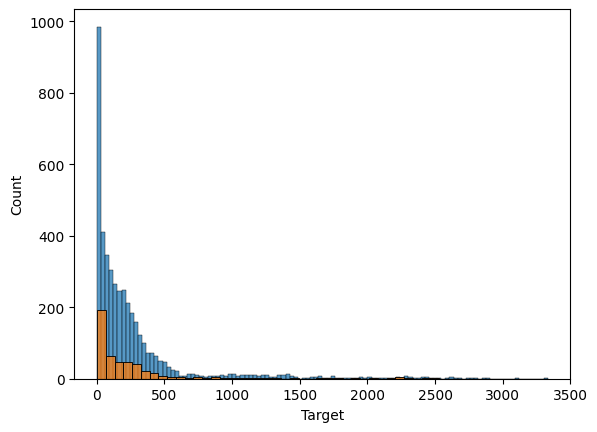

In [9]:
sns.histplot(Y_train)
sns.histplot(Y_test)

In [10]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.svm import LinearSVR

model = LinearSVR(C=0.001, dual=False, epsilon=0.01, loss="squared_epsilon_insensitive", tol=1e-05, random_state=rand)
pip = make_pipeline(model)
pip.fit(X_train, Y_train)

Pipeline(steps=[('linearsvr',
                 LinearSVR(C=0.001, dual=False, epsilon=0.01,
                           loss='squared_epsilon_insensitive', random_state=42,
                           tol=1e-05))])

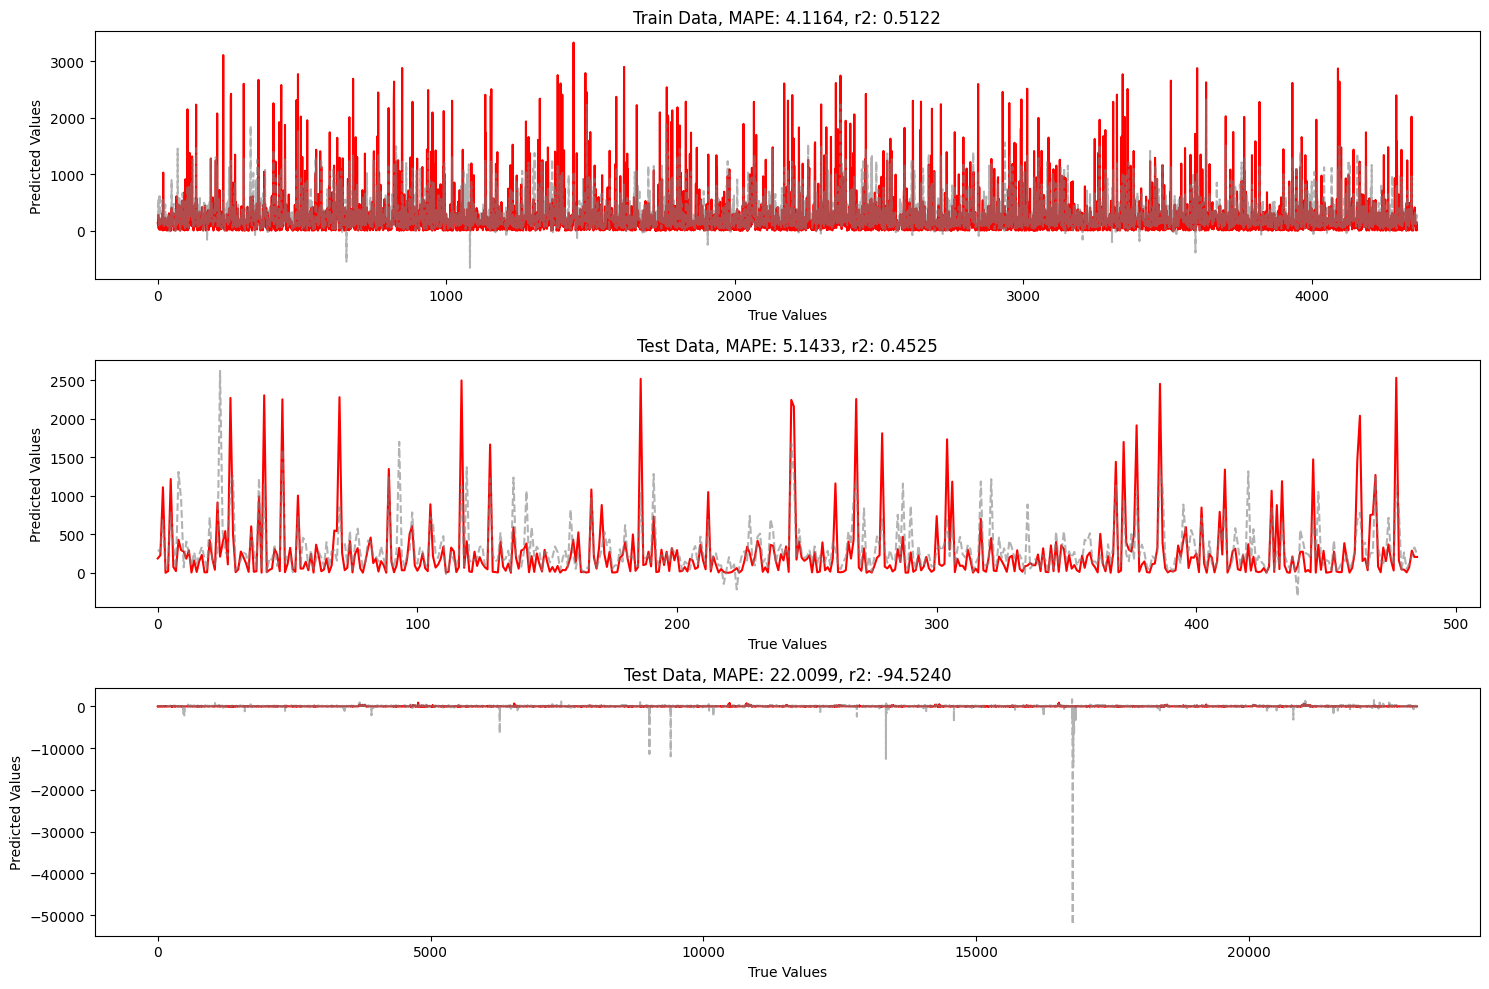

In [11]:
from sklearn.metrics import PredictionErrorDisplay

y_pred_i = pip.predict(X_train)
base = Y_train.loc[::]
pred = y_pred_i[::]
accuracy = (base == pred).mean()
mse = mean_absolute_percentage_error(base, pred)
r2 = r2_score(base, pred)

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

axes[0].plot(base.reset_index(drop=True), color='red', label='True')
axes[0].plot(pred, color='grey', alpha=0.6, linestyle='--', label='Predicted')
axes[0].set_title(f'Train Data, MAPE: {mse:.4f}, r2: {r2:.4f}')
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predicted Values')

y_pred_i = pip.predict(X_test)
base = Y_test
pred = y_pred_i[::]
accuracy = (base == pred).mean()
mse = mean_absolute_percentage_error(base, pred)
r2 = r2_score(base, pred)

display = PredictionErrorDisplay(y_true=base, y_pred=pred)

axes[1].plot(base.reset_index(drop=True), color='red', label='True')
axes[1].plot(pred, color='grey', alpha=0.6, linestyle='--', label='Predicted')
axes[1].set_title(f'Test Data, MAPE: {mse:.4f}, r2: {r2:.4f}')
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predicted Values')

y_pred_i = pip.predict(X_test_1)
base = Y_test_1.loc[::]
pred = y_pred_i[::]
accuracy = (base == pred).mean()
mse = mean_absolute_percentage_error(base, pred)
r2 = r2_score(base, pred)

axes[2].plot(base.reset_index(drop=True), color='red', label='True')
axes[2].plot(pred, color='grey', alpha=0.6, linestyle='--', label='Predicted')
axes[2].set_title(f'Test Data, MAPE: {mse:.4f}, r2: {r2:.4f}')
axes[2].set_xlabel('True Values')
axes[2].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_pinball_loss,
    root_mean_squared_error,
)

def consolidate_scores(cv_results, scores, metric):
    if metric == "MAPE":
        scores[metric].append(f"{value.mean():.2f} ± {value.std():.2f}")
    else:
        scores[metric].append(f"{value.mean():.1f} ± {value.std():.1f}")

    return scores

scoring = {
    "MAPE": make_scorer(mean_absolute_percentage_error),
    "RMSE": make_scorer(root_mean_squared_error),
    "MAE": make_scorer(mean_absolute_error),
    "pinball_loss_05": make_scorer(mean_pinball_loss, alpha=0.05),
    "pinball_loss_50": make_scorer(mean_pinball_loss, alpha=0.50),
    "pinball_loss_95": make_scorer(mean_pinball_loss, alpha=0.95),
}

In [13]:
from sklearn.base import defaultdict
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate

scores = defaultdict(list)
quantile_list = [0.05, 0.5, 0.95]

for quantile in quantile_list:
    model = HistGradientBoostingRegressor(loss="quantile", quantile=quantile)
    cv_results = cross_validate(
        model,
        X_train,
        Y_train,
        scoring=scoring,
        n_jobs=2,
    )
    time = cv_results["fit_time"]
    scores["fit_time"].append(f"{time.mean():.2f} ± {time.std():.2f} s")

    scores["loss"].append(f"quantile {int(quantile*100)}")
    for key, value in cv_results.items():
        if key.startswith("test_"):
            metric = key.split("test_")[1]
            scores = consolidate_scores(cv_results, scores, metric)

scores_df = pl.DataFrame(scores)
scores_df


/root/miniconda3/envs/testurl/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  pid = os.fork()


fit_time,loss,MAPE,RMSE,MAE,pinball_loss_05,pinball_loss_50,pinball_loss_95
str,str,str,str,str,str,str,str
"""0.81 ± 0.10 s""","""quantile 5""","""0.63 ± 0.02""","""422.5 ± 28.3""","""191.0 ± 10.8""","""10.9 ± 0.4""","""95.5 ± 5.4""","""180.1 ± 10.5"""
"""1.07 ± 0.26 s""","""quantile 50""","""0.98 ± 0.17""","""161.5 ± 8.5""","""87.1 ± 2.4""","""34.3 ± 3.0""","""43.6 ± 1.2""","""52.8 ± 3.5"""
"""0.74 ± 0.07 s""","""quantile 95""","""4.61 ± 0.48""","""263.9 ± 14.7""","""189.2 ± 8.3""","""170.7 ± 9.3""","""94.6 ± 4.1""","""18.5 ± 1.8"""


In [14]:
def min_arg(col):
    col_split = pl.col(col).str.split(" ")
    return pl.arg_sort_by(
        col_split.list.get(0).cast(pl.Float64),
        col_split.list.get(2).cast(pl.Float64),
    ).first()


scores_df.select(
    pl.col("loss").get(min_arg(col_name)).alias(col_name)
    for col_name in scores_df.columns
    if col_name != "loss"
)

fit_time,MAPE,RMSE,MAE,pinball_loss_05,pinball_loss_50,pinball_loss_95
str,str,str,str,str,str,str
"""quantile 95""","""quantile 5""","""quantile 50""","""quantile 50""","""quantile 5""","""quantile 50""","""quantile 95"""


In [15]:

max_iter = 50
gbrt_mean_poisson = HistGradientBoostingRegressor(loss="poisson", max_iter=max_iter)
gbrt_mean_poisson.fit(X_train, Y_train)
mean_predictions = gbrt_mean_poisson.predict(X_test_2)

gbrt_median = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.5, max_iter=max_iter
)
gbrt_median.fit(X_train, Y_train)
median_predictions = gbrt_median.predict(X_test_2)

gbrt_percentile_5 = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.05, max_iter=max_iter
)
gbrt_percentile_5.fit(X_train, Y_train)
percentile_5_predictions = gbrt_percentile_5.predict(X_test_2)

gbrt_percentile_95 = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.95, max_iter=max_iter
)
gbrt_percentile_95.fit(X_train, Y_train)
percentile_95_predictions = gbrt_percentile_95.predict(X_test_2)

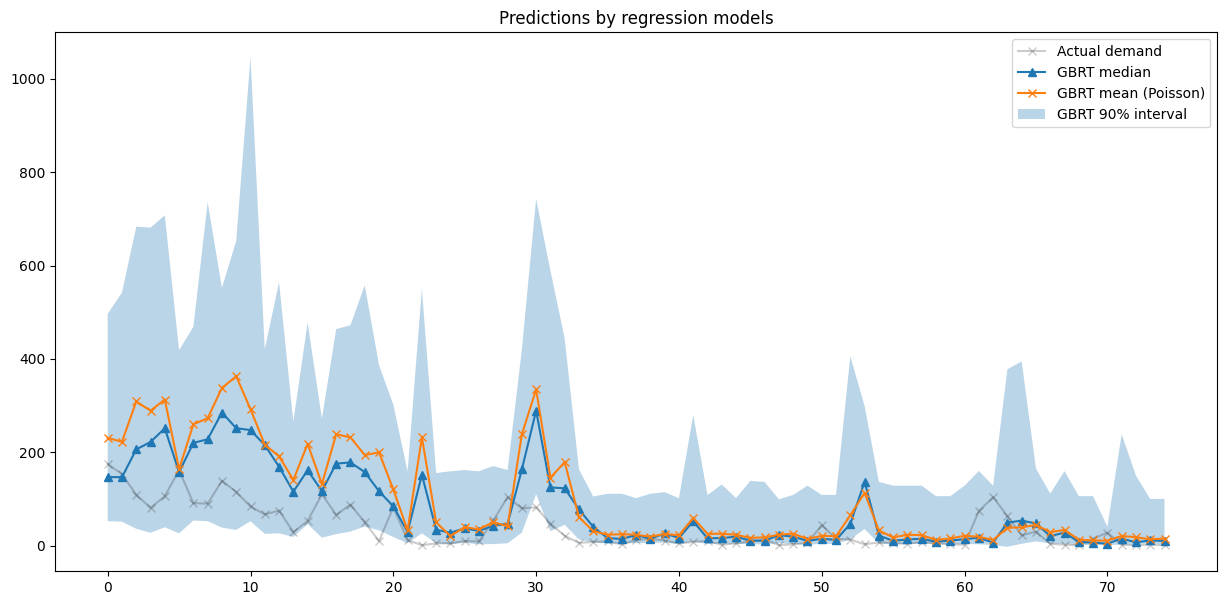

In [22]:
last_count = 75
last_hours = slice(-last_count, None)
fig, ax = plt.subplots(figsize=(15, 7))
plt.title("Predictions by regression models")
ax.plot(
    Y_test_2[last_hours].reset_index(drop=True),
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    median_predictions[last_hours],
    "^-",
    label="GBRT median",
)
ax.plot(
    mean_predictions[last_hours],
    "x-",
    label="GBRT mean (Poisson)",
)
ax.fill_between(
    np.arange(last_count),
    percentile_5_predictions[last_hours],
    percentile_95_predictions[last_hours],
    alpha=0.3,
    label="GBRT 90% interval",
)
_ = ax.legend()

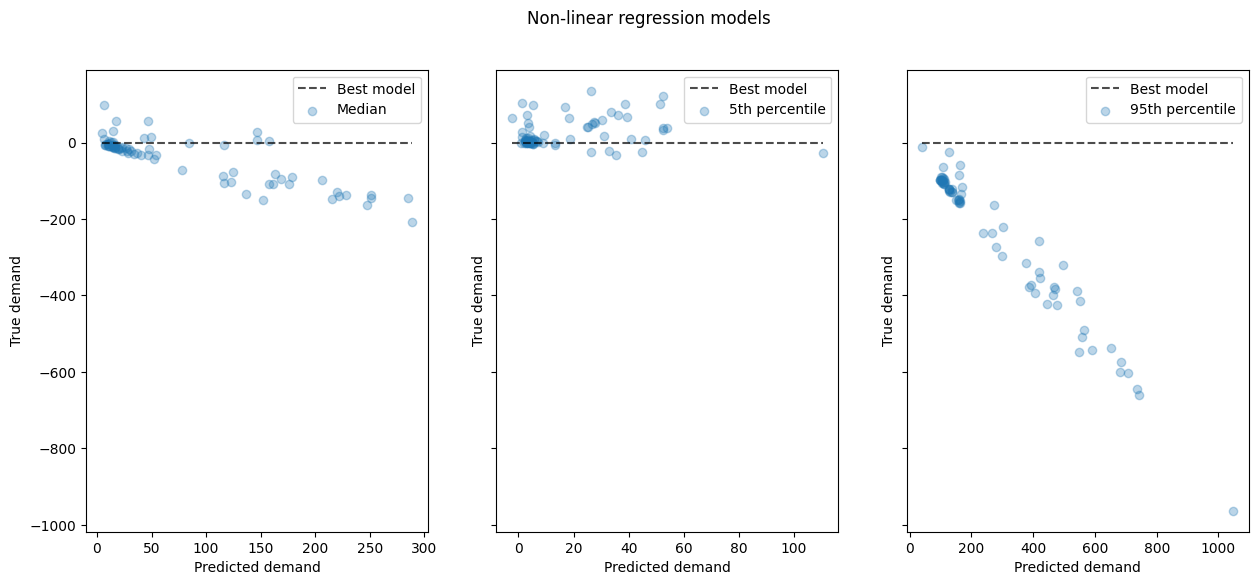

In [17]:
from sklearn.metrics import PredictionErrorDisplay

fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    median_predictions,
    percentile_5_predictions,
    percentile_95_predictions,
]
labels = [
    "Median",
    "5th percentile",
    "95th percentile",
]
for ax, pred, label in zip(axes, predictions, labels):
    PredictionErrorDisplay.from_predictions(
        y_true=Y_test_2,
        y_pred=pred,
        kind="residual_vs_predicted",
        scatter_kwargs={"alpha": 0.3},
        ax=ax,
    )
    ax.set(xlabel="Predicted demand", ylabel="True demand")
    ax.legend(["Best model", label])
    ax.set_ylabel("True demand")  # 显示y坐标轴的值

plt.show()

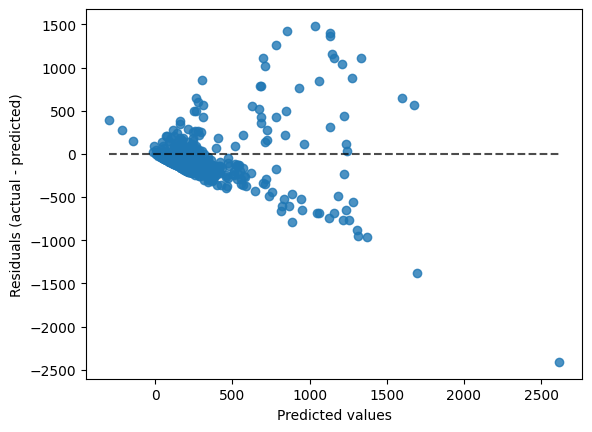

In [18]:
display.plot()

In [19]:
# 保存模型
import joblib

joblib.dump(pip, "model.jlib")


['model.jlib']

PermutationExplainer explainer: 487it [00:16, 13.06it/s]                         


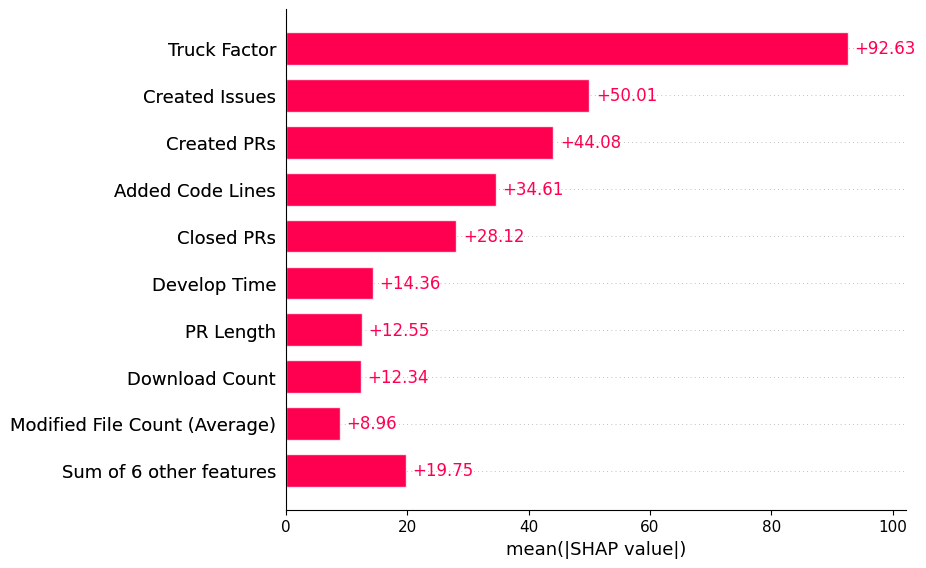

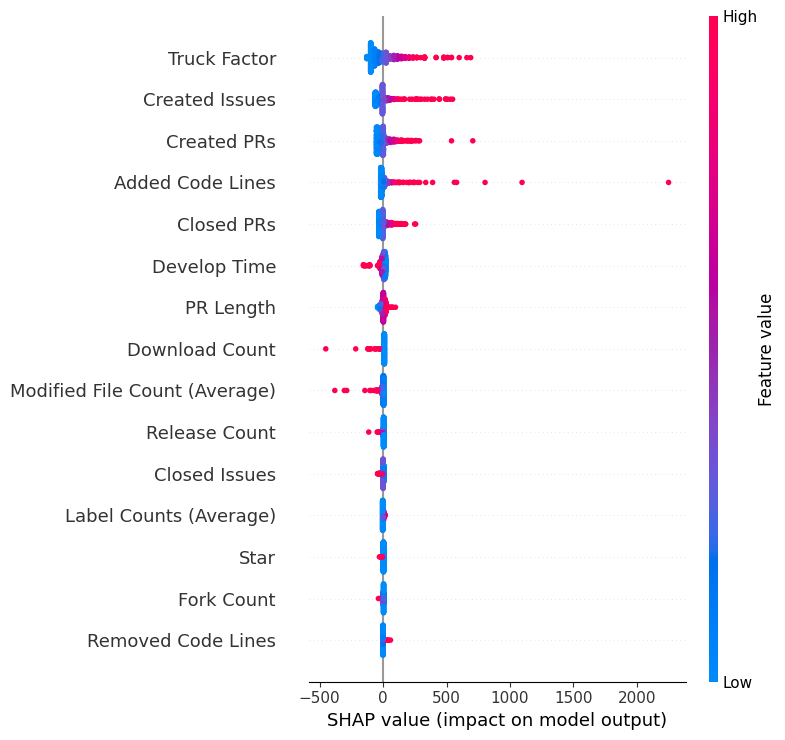

In [20]:
import shap
explainer = shap.Explainer(pip.predict, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values)